In [20]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

users = ['elonmusk' ,'cristiano','BarackObama', 'billgates','cnnbrk','joebiden','justinbieber','KimKardashian','theellenshow','twitter','youtube']


def get_data(path="basic"):
    df_from_each_file = (pd.read_csv(f'user_data/{path}_{user}_tweets.csv') for user in users)
    return pd.concat(df_from_each_file, ignore_index=True)

data_frame = pd.read_csv('main_df.csv')
data_annotations_frame = get_data('annotations')
old_elon_basic = pd.read_csv('old_elon_basic.csv')
old_elon_annotations = pd.read_csv('old_elon_annotations.csv')

used_annotations = 3
max_annotations = 6
    

columns_to_be_dropped = [
    'created at',
    'possibly sensitive',
    'retweet count',
    'reply count',
    'like count',
    'quote count',
    'annotations']

for i in range(max_annotations - used_annotations):
    domain = f'context annotations domain {used_annotations + i}'
    context = f'context annotations entity {used_annotations + i}'
    columns_to_be_dropped.extend([domain, context])

old_elon_data = pd.concat([old_elon_basic, old_elon_annotations], axis=1)
old_elon_data = old_elon_data.loc[:,~old_elon_data.columns.duplicated()].copy()
old_elon_data.drop(columns_to_be_dropped, axis=1, inplace=True)

latest_data = pd.concat([data_frame, data_annotations_frame], axis=1)
latest_data = latest_data.loc[:,~latest_data.columns.duplicated()].copy()
latest_data.drop(columns_to_be_dropped, axis=1, inplace=True)
latest_data = pd.concat([latest_data, old_elon_data], axis=0)



In [21]:
from sklearn.preprocessing import LabelEncoder 


for i in range(used_annotations):
    col_1, col_2 = f'context annotations domain {i}', f'context annotations entity {i}'
    latest_data = latest_data[latest_data[col_1].notnull()]
    latest_data = latest_data[latest_data[col_2].notnull()]

for col in ['source', 'lang']:
    le = LabelEncoder()
    latest_data[col]= le.fit_transform(latest_data[col])

for i in range(used_annotations):
    col_1, col_2 = f'context annotations domain {i}', f'context annotations entity {i}'
    le = LabelEncoder()
    latest_data[col_1]= le.fit_transform(latest_data[col_1])
    le = LabelEncoder()
    latest_data[col_2]= le.fit_transform(latest_data[col_2])

In [23]:
y = latest_data.iloc[:, 0]
x = latest_data.iloc[:, 1:]

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

mlp_classifier = MLPClassifier(hidden_layer_sizes = (150,), random_state = 42)
mlp_classifier.fit(x_train, y_train)

labels_predicted_mlp = mlp_classifier.predict(x_test)

print(f'MLPClassifier accuracy:  {100*accuracy_score(labels_predicted_mlp, y_test)}[%]')
print(classification_report(y_test, labels_predicted_mlp))
print(confusion_matrix(y_test, labels_predicted_mlp))

MLPClassifier accuracy:  98.55471438403303[%]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1250
           1       0.98      0.91      0.95       203

    accuracy                           0.99      1453
   macro avg       0.98      0.95      0.97      1453
weighted avg       0.99      0.99      0.99      1453

[[1247    3]
 [  18  185]]


In [29]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    X,
    y,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    

    plt.title('Learning curves')
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
   
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    plt.show()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

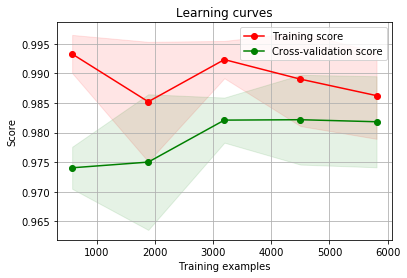

In [30]:
plot_learning_curve(mlp_classifier, x, y, cv=cv, n_jobs=4)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=4)

neigh.fit(x_train, y_train)

labels_predicted_neigh = neigh.predict(x_test)
print(f'KNeighborsClassifier accuracy:  {100*accuracy_score(labels_predicted_neigh, y_test)}[%]')
print(classification_report(y_test, labels_predicted_neigh))
print(confusion_matrix(y_test, labels_predicted_neigh))


KNeighborsClassifier accuracy:  97.24707501720579[%]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1250
           1       0.92      0.88      0.90       203

    accuracy                           0.97      1453
   macro avg       0.95      0.93      0.94      1453
weighted avg       0.97      0.97      0.97      1453

[[1235   15]
 [  25  178]]


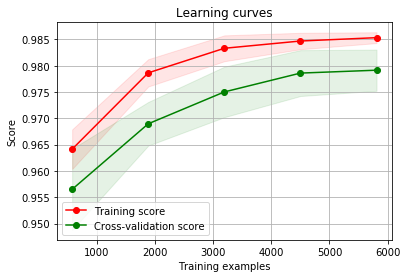

In [32]:
plot_learning_curve(neigh, x, y, cv=cv, n_jobs=4)

In [33]:
from sklearn import tree

tree = tree.DecisionTreeClassifier()
tree = tree.fit(x_train, y_train)

labels_predicted_tree = tree.predict(x_test)
print(f'DecisionTreeClassifier accuracy:  {100*accuracy_score(labels_predicted_tree, y_test)}[%]')
print(classification_report(y_test, labels_predicted_tree))
print(confusion_matrix(y_test, labels_predicted_tree))

DecisionTreeClassifier accuracy:  98.8988300068823[%]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1250
           1       0.97      0.95      0.96       203

    accuracy                           0.99      1453
   macro avg       0.98      0.97      0.98      1453
weighted avg       0.99      0.99      0.99      1453

[[1244    6]
 [  10  193]]


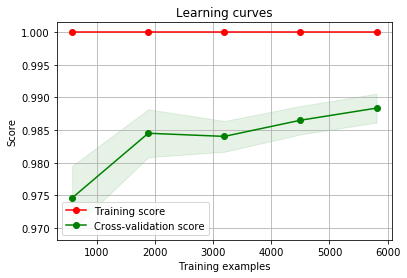

In [34]:
plot_learning_curve(tree, x, y, cv=cv, n_jobs=4)